<a href="https://colab.research.google.com/github/Khadijah-Trawally/QuantumGraphColoring/blob/main/test_graph_coloring_hamiltonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os

import numpy as np

import matplotlib.pyplot as plt
from scipy.linalg import eigh
import networkx as nx


In [2]:
### ___Corrections____###

# return the expectation
# convert to binary using a for loop and conditional statement
# loop over the GS return of list of bit stringfor both degenerate state
# dont average the state ,
# change the topology of the graph, and edges  and also the number of colors
#N= 8 , c= 3

### need to select the inten

In [3]:
def draw_graph(N, edges, node_color = None):
    """
    Generate and draw a graph with a given structure

    Parameters
    ----------
    num_nodes : int
        Number of nodes of the graph
    edges : list of tuples of ints
        Edges of the graph
    node_color : color or array of colors, optional
         Node color


    Returns
    -------
    nx.Graph
        Graph object
    """


    seed = 12345
    graph = nx.Graph()
    graph.add_nodes_from([ii for ii in range(N)])
    graph.add_edges_from(edges)


    pos = nx.spring_layout(graph, seed=seed)

    nx.draw(graph, with_labels=True, pos=pos, node_size=700, node_color = node_color)


    return graph

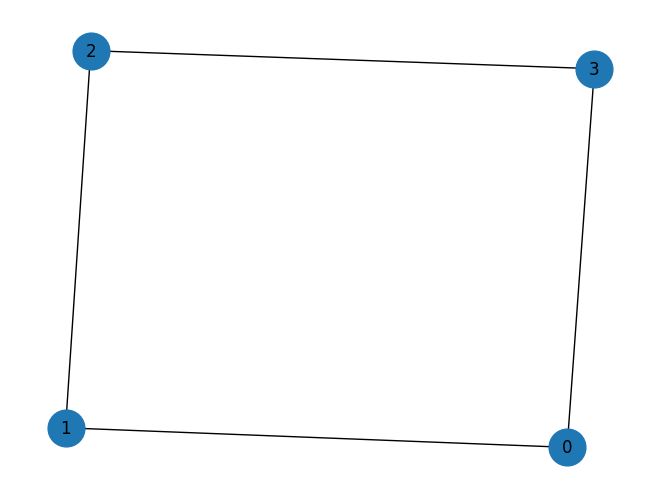

In [4]:
edges = [(0, 1), (1, 2), (2, 3), (3 , 0)]
num_nodes = 4


G = draw_graph(num_nodes, edges)
G



In [5]:
def get_1d_index(i, k, c):
    """
    Convert 2D index (i, k) to a 1D index in a grid with 'c' number of columns.

    Parameters:
    i (int): Node index.
    k (int): Color index.
    c (int): Number of colors.

    Returns:
    int: Corresponding 1D index.
    """
    return i * c + k

def constant_terms(N, C, graph, lambda1, lambda2):
    """
    Construct the constants P for the Hamiltonian.

    Parameters:
    N (int): Number of nodes.
    C (int): Number of colors.
    graph (networkx.Graph): Graph representing the nodes and edges.
    lambda1 (float): Coefficient for the first two terms.
    lambda2 (float): Coefficient for the third term.

    Returns:
    P (float): constant in the Hamiltonian.

    """
    E = graph.number_of_edges()
    P = 0.25 * lambda1 * (4 * N * C + N * C * (C - 3)) + 0.25 * lambda2 * C * E

    return P


def magnetic_fields(N, C, graph, lambda1, lambda2):
    """
    Construct the magnetic fields h for the Hamiltonian.

    Parameters:
    N (int): Number of nodes.
    C (int): Number of colors.
    graph (networkx.Graph): Graph representing the nodes and edges.
    lambda1 (float): Coefficient for the first two terms.
    lambda2 (float): Coefficient for the third term.

    Returns:
    numpy.ndarray: Magnetic fields vector.
    """
    # sigmaz = np.array([[1, 0], [0, -1]], dtype=complex)
    dim = N * C
    h = np.zeros(dim, dtype=complex)

    # First term: (1/2) * lambda1 * sum_{i=1}^{n} sum_{k=1}^{c} (c-k-1) * sigma_{ik}
    for i in range(N):
        for k in range(C):
            ik = get_1d_index(i, k, C)
            coefficient = (C - k - 1)
            h[ik] += 0.5 * lambda1 * coefficient

    # Second term: (1/2) * lambda1 * sum_{i=1}^{n} sum_{k' > k=1}^{c} sigma_{ik'}
    for i in range(N):
        for k in range(C - 1):
            for k_prime in range(k + 1, C):
                ik_prime = get_1d_index(i, k_prime, C)
                h[ik_prime] += 0.5 * lambda1

    # Third term: (1/4) * lambda2 * sum_{(i,j) in E} sum_{k=1}^{c} (sigma_{ik} + sigma_{jk})
    for i, j in graph.edges:
        for k in range(C):
            ik = get_1d_index(i, k, C)

            jk = get_1d_index(j, k, C)
            h[ik] += 0.25 * lambda2
            h[jk] += 0.25 * lambda2

    return h

def interaction_strengths(N, C, graph, lambda1, lambda2):
    """
    Construct the interaction strengths matrix J.

    Parameters:
    N (int): Number of nodes.
    C (int): Number of colors.
    graph (networkx.Graph): Graph representing the nodes and edges.
    lambda1 (float): penalty constant, Coefficient for the first term.
    lambda2 (float): penalty constant, Coefficient for the second term.

    Returns:
    numpy.ndarray: Interaction strengths matrix J.
    """
    dim = N * C
    J = np.zeros((dim, dim), dtype=complex)

    # First term: (1/2) * lambda1 * sum_{i=1}^{n} sum_{k' > k=1}^{c} sigma_{ik} sigma_{ik'}
    for i in range(N):
        for k in range(C - 1):
            for k_prime in range(k + 1, C):
                ik = get_1d_index(i, k, C)
                ik_prime = get_1d_index(i, k_prime, C)
                J[ik, ik_prime] = 0.5 * lambda1

    # Second term: (1/4) * lambda2 * sum_{(i,j) in E} sum_{k=1}^{c} sigma_{ik} sigma_{jk}
    for i, j in graph.edges:
        for k in range(C):
            ik = get_1d_index(i, k, C)
            jk = get_1d_index(j, k, C)
            J[ik, jk] = 0.25 * lambda2

    return J


In [6]:

def generate_hamiltonian(N, h, J, cont):
    """
      Generate the Hamiltonian matrix for a quantum Ising model with given parameters.

      Parameters:
      N : int
          Number of spins in the system.
      h : np.ndarray
          Magnetic field array.
      J : np.ndarray
          Interaction strengths matrix.
      cont : float
          Constant term.

      Returns:
      np.ndarray
          Hamiltonian matrix.
    """
    sz = np.array([[1, 0], [0, -1]])
    ham = np.zeros((2**N, 2**N), dtype=complex)

    for ii in range(N):
        # On-site terms
        op = np.identity(2**ii)
        op = np.kron(op, sz)
        op = np.kron(op, np.identity(2**(N-ii-1)))
        ham += h[ii] * op

    for ii in range(N):
        for jj in range(ii+1, N):
            # Interaction term
            op = np.identity(2**ii)
            op = np.kron(op, sz)
            op = np.kron(op, np.identity(2**(jj-ii-1)))
            op = np.kron(op, sz)
            op = np.kron(op, np.identity(2**(N-jj-1)))
            ham += J[ii, jj] * op

    ham += cont * np.identity(2**N)

    return ham







def ground_state_solution(hamiltonian):
    """
    Find the ground states of a given Hamiltonian.

    Parameters:
    hamiltonian : np.ndarray
        Hamiltonian matrix.

    Returns:
    np.ndarray
        ground states.
    """

    eigenvalues, eigenvectors = eigh(hamiltonian)
    ground_energy = eigenvalues[0]

    # idx = np.isclose(eigenvalues, ground_energy)
    # ground_states = eigenvectors[:, idx]

    ground_states = eigenvectors[:, 0]
    #print(ground_states)

    return  ground_energy, ground_states




def expected_value(state, operator):
    """
    Calculate the expectation value of the operator with respect to the state.

    Parameters:
    state : np.ndarray
        State vector.
    operator : np.ndarray
        Operator matrix.

    Returns:
    float
        Expectation value.
    """
    return np.real(np.conj(state).T @ operator @ state)

def generate_bitstrings_from_expected_values(N, ground_state):
    """
    Calculate the bitstrings from expectation values of the Pauli-Z operator for each site.

    Parameters:
    N : int
        Number of qubits.
    ground_states : np.ndarray
        Ground state vector (2^N).

    Returns:
    np.ndarray
       return the bit strings for each qubit.
    """
    sz = np.array([[1, 0], [0, -1]])
    # num_ground_states = ground_states.shape[1]
    bit_string = np.zeros(N)

    for j in range(N):
        # Initialize the operator as an identity matrix
        op = np.identity(1)
        for k in range(N):
            if k == j:
                op = np.kron(op, sz)
            else:
                op = np.kron(op, np.identity(2))



        ground_state = ground_state / np.linalg.norm(ground_state)  # Normalize the ground state
        expectation_value = expected_value(ground_state, op)

        #converting expectation values to bitstrings

        if expectation_value == -1:


          bit_string[j] += 0

        else:

          bit_string[j] += expectation_value


    return bit_string

#
def generate_ising_hamiltonian(n, c, G, lambda1 = 4, lambda2 = -4):
    """
    Generate the Hamiltonian for a quantum Ising model and compute the expectation values
    of the Pauli Z matrix at each site for the ground state.

    Parameters:
    n : int
        Number of spins (qubits) in the system.
    c : float
        Constant term for Hamiltonian construction.
    G : np.ndarray
        Interaction graph matrix.
    lambda1 : float, optional
        Parameter for the magnetic fields (default is 4).
    lambda2 : float, optional
        Parameter for the interaction strengths (default is -2).

    Returns:
    np.ndarray
        Expectation values of the Pauli Z matrix at each site.
    """


    # Construct the constants
    P = constant_terms(n, c, G, lambda1, lambda2)


    # Construct the magnetic fields
    h = magnetic_fields(n, c, G, lambda1, lambda2)


    # Construct the interaction strengths matrix
    J = interaction_strengths(n, c, G, lambda1, lambda2)


    hamiltonian = generate_hamiltonian(n, h, J, P)
    #print(f'The ham shape: {hamiltonian.shape} \n')
    ground_energy, ground_state = ground_state_solution(hamiltonian)


    bit_string_values = generate_bitstrings_from_expected_values(n, ground_state)

    print("bit strings values of sigma_z at each site:", bit_string_values)

    return  bit_string_values


def assign_color(result, num_color):
    """
    Generate the color map based on the result array and the number of colors.

    Parameters:
    result : np.ndarray
        Array representing the state of spins (qubits) in the system.
    num_color : int
        Number of colors to be used.

    Returns:
    list
        List of color assignments.
    """
    colors = ['blue', 'red', 'green', 'yellow', 'black', 'pink', 'purple']
    color_map = []

    for idx, val in enumerate(result):
        if val == 1:
            color = idx % num_color
        else:
            color = idx % num_color
        color_map.append(colors[color])

    return color_map


bit strings values of sigma_z at each site: [1. 0. 1. 0.]


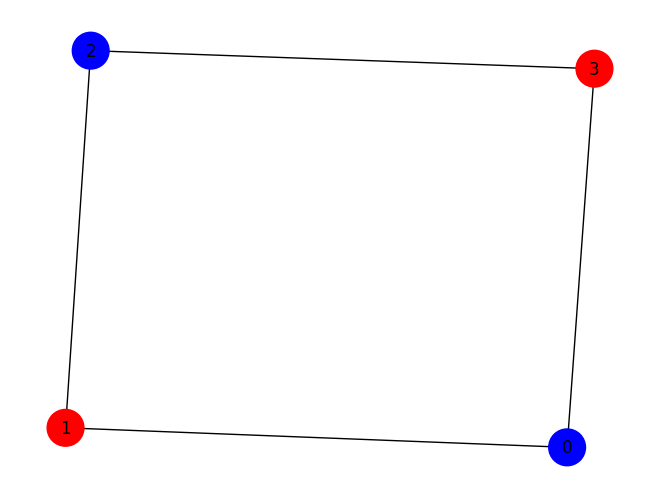

In [7]:

if __name__ == '__main__':

  N = 4
  C = 2
  result = generate_ising_hamiltonian(N, C, G, lambda1 = 4, lambda2 = -2)
  node_colors = assign_color(result, C)


  graph = draw_graph(N, edges, node_colors)




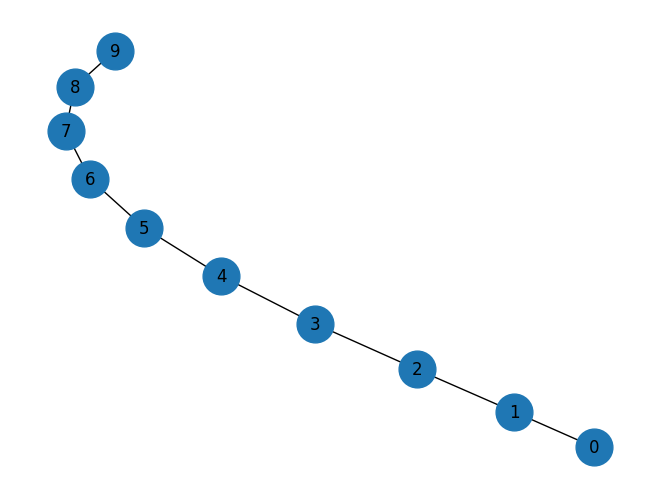

In [8]:
num_nodes= 10
color = 2
edges = [ (ii, ii+1) for ii in range(num_nodes-1)]

G_line = draw_graph(num_nodes, edges)


bit strings values of sigma_z at each site: [1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


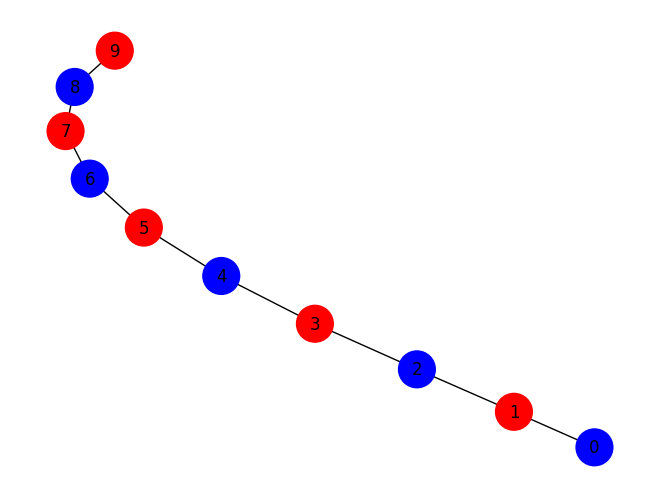

In [9]:

if __name__ == '__main__':

  N = 10
  C = 2
  opt_sol = generate_ising_hamiltonian(num_nodes, color, G_line )
  node_colors = assign_color(opt_sol, C)

  draw_graph(N, edges, node_colors)


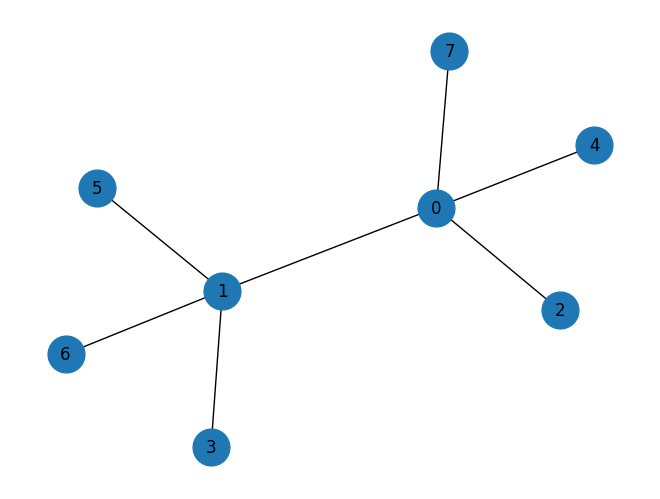

In [10]:

if __name__ == '__main__':

  N1 = 8
  C1 = 3
  edges= [(0, 1), (0, 2),(0, 7),(0, 4), (1, 5), (1, 6), (1, 3)]



  graph_dia =draw_graph(N1, edges)

bit strings values of sigma_z at each site: [0. 0. 1. 0. 0. 1. 0. 0.]


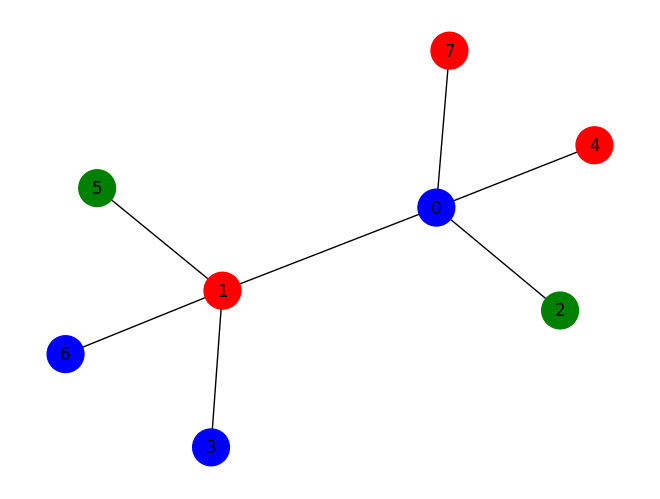

In [11]:
opt_sol1 = generate_ising_hamiltonian(N1, C1, graph_dia )
node_colors1 = assign_color(opt_sol1, C1)




draw_graph(N1, edges, node_colors1)

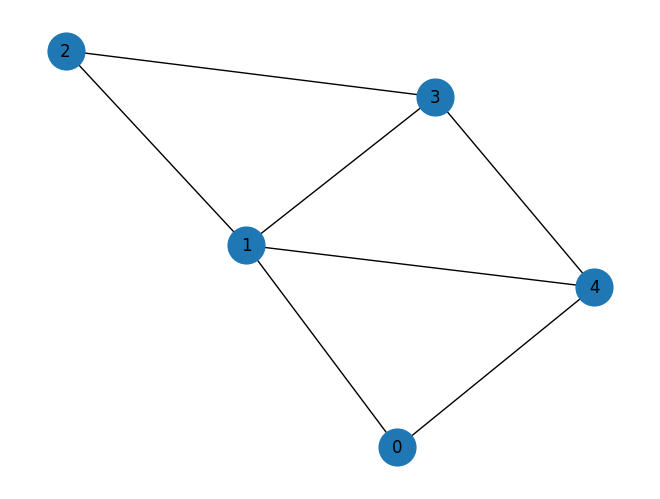

In [12]:

if __name__ == '__main__':

  N = 5
  C = 3


  edges= [(0, 1), (0, 4), (1, 2), (1, 3),(4, 1), (2, 3), (3, 4)]


  graph_com =draw_graph(N, edges)

bit strings values of sigma_z at each site: [1. 0. 0. 1. 0.]


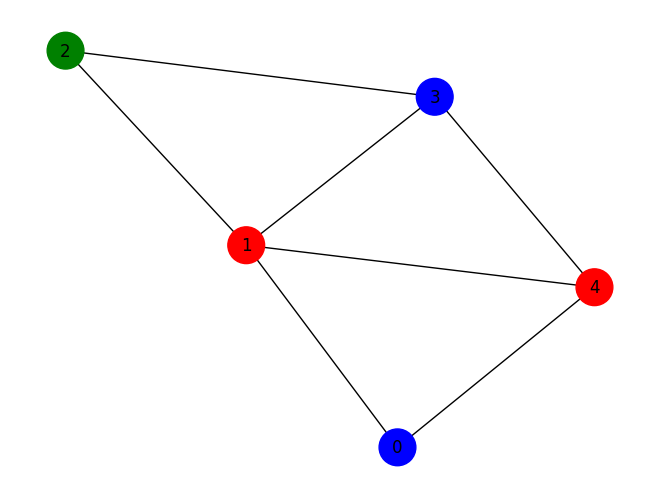

In [13]:
opt_sol_com = generate_ising_hamiltonian(N, C, graph_com )

node_colors1= assign_color(opt_sol_com, C)

draw_graph(N, edges, node_colors1)

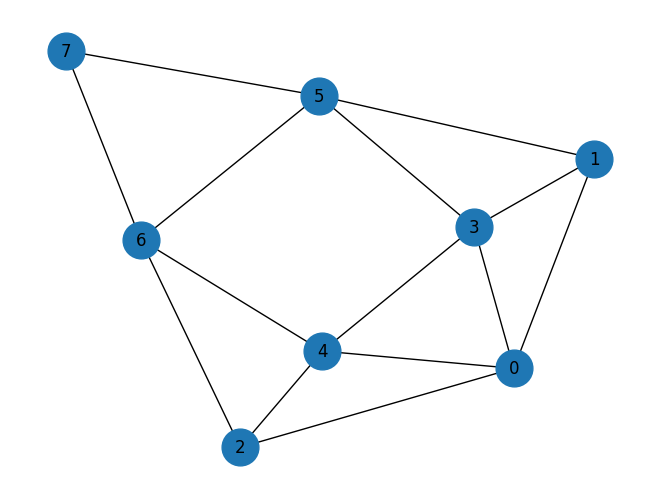

In [14]:
if __name__ == '__main__':

  N = 8
  C = 3

  edges= [(0, 1), (0, 2),(0,  3),(0, 4), (1, 3),(1, 5), (2, 4),(2, 6), (3, 4), (3 , 5),  (4, 6), (5, 6),(5, 7), (6, 7)]



  graph_com =draw_graph(N, edges)

bit strings values of sigma_z at each site: [1. 0. 0. 1. 0. 0. 1. 0.]


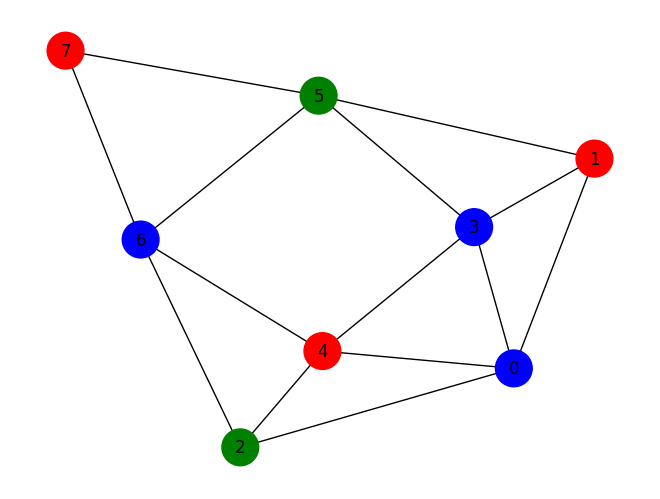

In [15]:
opt_sol_com = generate_ising_hamiltonian(N, C, graph_com )

node_colors= assign_color(opt_sol_com, C)

draw_graph(N, edges, node_colors)

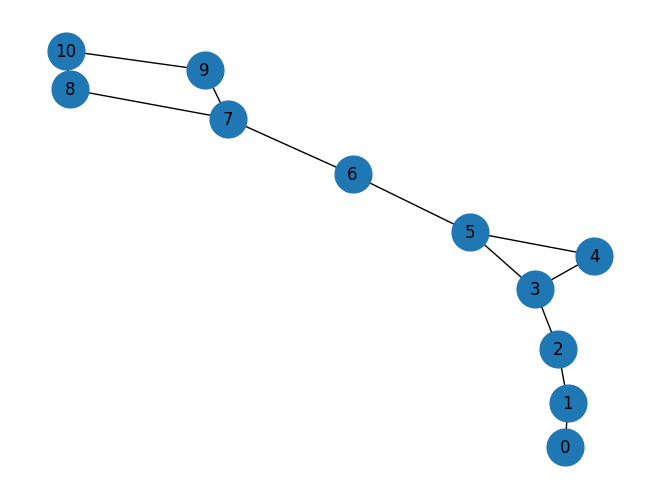

In [16]:
edgesList= [(0, 1), (1, 2), (2, 3), (3, 4), (3, 5),
            (4, 5), (5, 6), (6, 7),  (6, 7), (7, 8),
             (7, 8), (7, 9), (8, 10), (9, 10)]
N = 11
C= 3

graph_list =draw_graph(N, edgesList)

bit strings values of sigma_z at each site: [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]


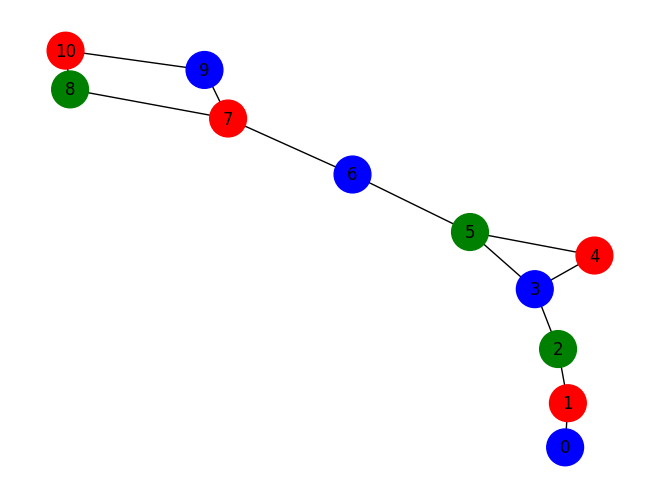

In [17]:
res = generate_ising_hamiltonian(N, C, graph_com )

node_colors= assign_color(res, C)

draw_graph(N, edgesList, node_colors)